# Fashion Detection: Image Classification with CNN
authors: [@MelissaPerez09](https://github.com/MelissaPerez09), [@bl33h](https://github.com/bl33h), [@Mendezg1](https://github.com/Mendezg1)

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import numpy as np

In [2]:
# dirs
images_dir = "../colorful_fashion_dataset_for_object_detection/JPEGImages/"
annotations_dir = "../colorful_fashion_dataset_for_object_detection/Annotations/"
labels = "../colorful_fashion_dataset_for_object_detection/labels.txt"

In [3]:
image_files = os.listdir(images_dir)
image_ids = [os.path.splitext(file)[0] for file in image_files if file.lower().endswith(('.jpg', '.jpeg', '.png'))]

In [4]:
# read labels
with open(labels, 'r') as f:
    labels = [label.strip().replace(',', '') for label in f.read().splitlines()]

# map labels to integers
label_map = {label: idx for idx, label in enumerate(labels)}

print(label_map)

{'sunglass': 0, 'hat': 1, 'jacket': 2, 'shirt': 3, 'pants': 4, 'shorts': 5, 'skirt': 6, 'dress': 7, 'bag': 8, 'shoe': 9}


In [5]:
# load image and bounding boxes
def load_image_and_boxes(image_id):
    # load image
    image_path = os.path.join(images_dir, f"{image_id}.jpg")
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # load bounding boxes (annotations xml)
    annotation_path = os.path.join(annotations_dir, f"{image_id}.xml")
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    
    boxes = []
    labels = []
    
    for obj in root.findall('object'):
        label = obj.find('name').text
        bbox = obj.find('bndbox')
        
        # bounding box coordinates
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        
        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(label_map[label])
    
    return image, boxes, labels

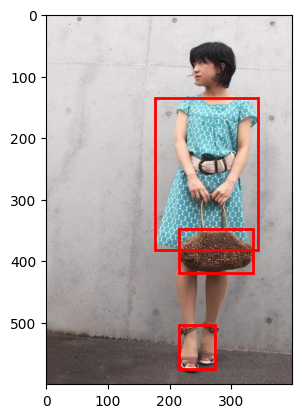

In [6]:
# visualize image and bounding boxes

image, boxes, labels = load_image_and_boxes(image_ids[0])

plt.imshow(image)
for box in boxes:
    xmin, ymin, xmax, ymax = box
    plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='red', linewidth=2))
plt.show()

In [7]:
cropped_images_array = []

def normalize_image(image):
    return image / 255.0

# Function to crop and normalize images, and save them in an array
def crop_normalize_and_save_images_to_array(image_id, cropped_images_array, target_size=(128, 128)):
    image, boxes, labels = load_image_and_boxes(image_id)
    
    for idx, box in enumerate(boxes):
        xmin, ymin, xmax, ymax = box
        cropped_image = image[ymin:ymax, xmin:xmax]
        resized_image = cv2.resize(cropped_image, target_size)
        normalized_image = normalize_image(resized_image)
        cropped_images_array.append((normalized_image, labels[idx]))

for image_id in image_ids[:2144]:
    crop_normalize_and_save_images_to_array(image_id, cropped_images_array)


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

X = np.array([entry[0] for entry in cropped_images_array])
y = np.array([entry[1] for entry in cropped_images_array])

# Convert labels to categorical
y = to_categorical(y, num_classes=len(label_map))

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=X.shape[1:]),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_map), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X, y, epochs=40, batch_size=32, validation_split=0.2)

C:\Users\sarap\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 45s 198ms/step - accuracy: 0.2520 - loss: 2.1092 - val_accuracy: 0.4491 - val_loss: 1.6454
Epoch 2/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 38s 184ms/step - accuracy: 0.4165 - loss: 1.6493 - val_accuracy: 0.5093 - val_loss: 1.3713
Epoch 3/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 38s 182ms/step - accuracy: 0.5306 - loss: 1.3498 - val_accuracy: 0.5763 - val_loss: 1.2156
Epoch 4/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 38s 181ms/step - accuracy: 0.5959 - loss: 1.1683 - val_accuracy: 0.6335 - val_loss: 1.0746
Epoch 5/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 38s 181ms/step - accuracy: 0.6479 - loss: 1.0183 - val_accuracy: 0.6389 - val_loss: 1.0795
Epoch 6/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 37s 178ms/step - accuracy: 0.6937 - loss: 0.8787 - val_accuracy: 0.6594 - val_loss: 1.0183
Epoch 7/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 40s 194ms/step - accuracy: 0.7352 - loss: 0.7678 - val_accuracy: 0.6504 - val_loss: 1.0686
Epoch 8/40
208/208 ━━━━━━━━━━━━━━━━━━━━ 41s 198ms/step - accuracy: 0.7649 - loss: 0

In [9]:
cropped_test_images = []

for image_id in image_ids[2145:2682]:
    crop_normalize_and_save_images_to_array(image_id, cropped_test_images)

X_test = np.array([entry[0] for entry in cropped_test_images])
y_test = np.array([entry[1] for entry in cropped_test_images])

y_test = to_categorical(y_test, num_classes=len(label_map))

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.6806 - loss: 2.1402
Test Loss: 2.157254934310913
Test Accuracy: 0.6728880405426025


In [12]:
import joblib

joblib.dump(model, 'fashion_detection_model.pkl')

['fashion_detection_model.pkl']

# DEMO: Fashion detection

In [13]:
# import model
import dill

with open('fashion_detection_model.pkl', 'rb') as file:
    model = dill.load(file)

In [14]:
# prepare images for prediction
import cv2
import numpy as np
import matplotlib.pyplot as plt

# preprocess image without bounding box
def preprocess_image(image_path, target_size=(128, 128)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(image, target_size)  # Resize the full image
    normalized_image = resized_image / 255.0
    return np.expand_dims(normalized_image, axis=0)  # Add batch dimension

## First demo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


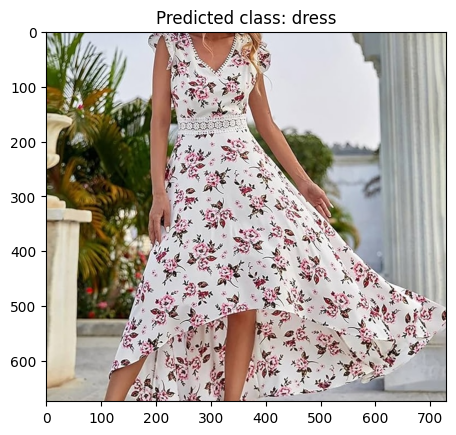

Execution time: 0.09 seconds


In [ ]:
import time
import cv2
import matplotlib.pyplot as plt
import numpy as np

# make prediction
image_path = 'demoImages/dress.jpg'

# start time measurement
start_time = time.time()

# preprocess image
input_image = preprocess_image(image_path)

# predict
prediction = model.predict(input_image)
predicted_label = np.argmax(prediction)  # gets label with highest probability

# maps label to class
label_map_inv = {v: k for k, v in label_map.items()}
predicted_class = label_map_inv[predicted_label]

# end time measurement
end_time = time.time()

# visualize the image result
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.title(f"Predicted class: {predicted_class}")
plt.show()

# print execution time
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

## Second demo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


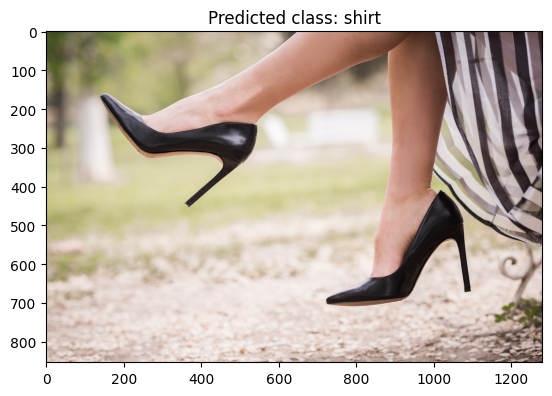

Execution time: 0.09 seconds


In [ ]:
# make prediction
image_path = 'demoImages/shoes.jpg'

# start time measurement
start_time = time.time()

# preprocess image
input_image = preprocess_image(image_path)

# predict
prediction = model.predict(input_image)
predicted_label = np.argmax(prediction)  # gets label with highest probability

# maps label to class
label_map_inv = {v: k for k, v in label_map.items()}
predicted_class = label_map_inv[predicted_label]

# end time measurement
end_time = time.time()

# visualize the image result
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.title(f"Predicted class: {predicted_class}")
plt.show()

# print execution time
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

## Third demo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


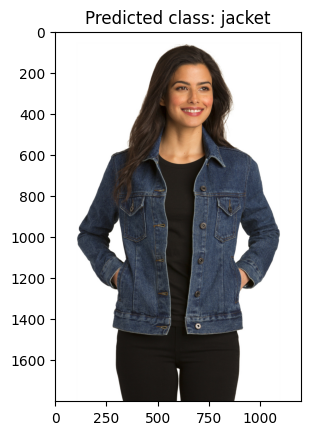

Execution time: 0.10 seconds


In [25]:
# make prediction
image_path = 'demoImages/jacket.jpg'

# start time measurement
start_time = time.time()

# preprocess image
input_image = preprocess_image(image_path)

# predict
prediction = model.predict(input_image)
predicted_label = np.argmax(prediction)  # gets label with highest probability

# maps label to class
label_map_inv = {v: k for k, v in label_map.items()}
predicted_class = label_map_inv[predicted_label]

# end time measurement
end_time = time.time()

# visualize the image result
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.title(f"Predicted class: {predicted_class}")
plt.show()

# print execution time
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

## Fourth demo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


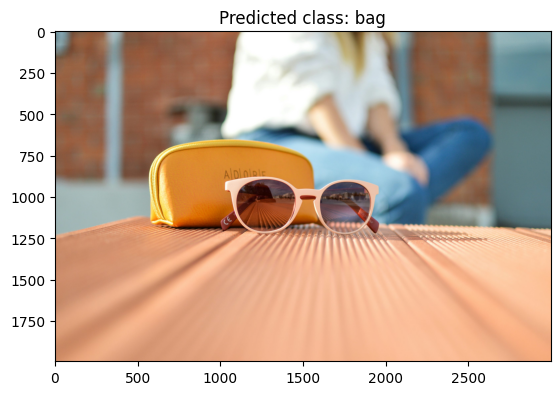

Execution time: 0.23 seconds


In [26]:
# make prediction
image_path = 'demoImages/sunglass.jpeg'

# start time measurement
start_time = time.time()

# preprocess image
input_image = preprocess_image(image_path)

# predict
prediction = model.predict(input_image)
predicted_label = np.argmax(prediction)  # gets label with highest probability

# maps label to class
label_map_inv = {v: k for k, v in label_map.items()}
predicted_class = label_map_inv[predicted_label]

# end time measurement
end_time = time.time()

# visualize the image result
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.title(f"Predicted class: {predicted_class}")
plt.show()

# print execution time
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


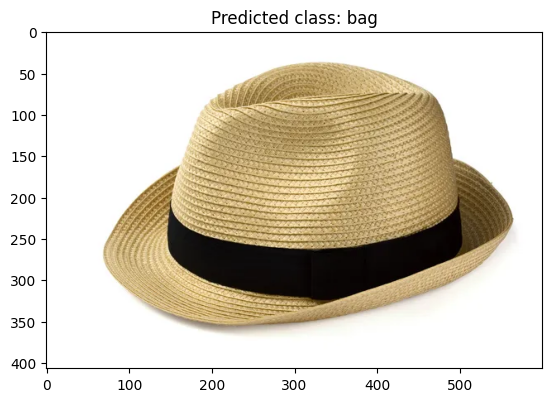

Execution time: 0.11 seconds


In [27]:
# make prediction
image_path = 'demoImages/hat.jpg'

# start time measurement
start_time = time.time()

# preprocess image
input_image = preprocess_image(image_path)

# predict
prediction = model.predict(input_image)
predicted_label = np.argmax(prediction)  # gets label with highest probability

# maps label to class
label_map_inv = {v: k for k, v in label_map.items()}
predicted_class = label_map_inv[predicted_label]

# end time measurement
end_time = time.time()

# visualize the image result
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.title(f"Predicted class: {predicted_class}")
plt.show()

# print execution time
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")